In [1]:
%pylab inline
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid_at_node
from landlab.components import PresFlowNetwork, MeltCreep
import numpy as np
from matplotlib import colors,  cm
import matplotlib.animation as animation

Populating the interactive namespace from numpy and matplotlib


In [2]:
from PIL import Image
from PIL import ImageDraw

def plot_links(grid, value_name, autoscale=True, vmin=0., vmax=0., cmap_name='viridis', magnitude= False, lw=5, pixels_per_node=15, x_name='X', y_name='Y', var_name='', use_PIL=True):#, logvalues=False ):
    if use_PIL:
        pixel_xscaling_factor = pixels_per_node/grid.dx
        pixel_yscaling_factor = pixels_per_node/grid.dy
        im = Image.new('RGBA', ( int(round(grid.number_of_cell_columns*pixel_xscaling_factor)), int(round(grid.number_of_cell_rows*pixel_yscaling_factor)) ), (255,255,255,255))
        draw = ImageDraw.Draw(im)

    link_head_x = grid.node_x[grid.node_at_link_head]
    link_head_y = grid.node_y[grid.node_at_link_head]
    link_tail_x = grid.node_x[grid.node_at_link_tail]
    link_tail_y = grid.node_y[grid.node_at_link_tail]       
    if magnitude:
        values = abs(grid.at_link[value_name])
    else:
        values = grid.at_link[value_name]
    #if logvalues:
    #    values = np.log10(abs(grid.at_link[value_name]))
    
    
    #Normalize color values
    if autoscale:
        cnorm = colors.Normalize()
        cnorm.autoscale(values)
    else:
        cnorm = colors.Normalize(vmin,vmax)
    scalarMap = cm.ScalarMappable(norm=cnorm, cmap = get_cmap(cmap_name))
    scalarMap.set_array(values)
    #set_cmap()
    if use_PIL:
        for i, value in enumerate(values):
            draw.line( ((link_head_x[i]*pixel_xscaling_factor,link_head_y[i]*pixel_yscaling_factor),(link_tail_x[i]*pixel_xscaling_factor,link_tail_y[i]*pixel_yscaling_factor)),fill=scalarMap.to_rgba(value,bytes=True),width=lw) 
        imshow(np.asarray(im), origin='lower', extent=(0,grid.number_of_cell_columns,0,grid.number_of_cell_rows))
    else:
        for i, value in enumerate(values):
            xs = [link_head_x[i],link_tail_x[i]]
            ys = [link_head_y[i],link_tail_y[i]]
            img = plot(xs,ys,lw=lw,color=scalarMap.to_rgba(value))    
    cb = colorbar(scalarMap)
    cb.ax.set_ylabel(var_name)
    xlabel(x_name)
    ylabel(y_name)


In [3]:
mg = RasterModelGrid((25,25),500)
junc_elev = mg.add_zeros('node', 'junction__elevation')
R = mg.add_zeros('node', 'input__discharge')
h = mg.add_zeros('node', 'hydraulic__head')
Q = mg.add_zeros('link', 'conduit__discharge')

#set heads at edges
h[mg.nodes_at_left_edge] = 10.
h[mg.nodes_at_right_edge] = 0.
h[mg.nodes_at_top_edge] = 0.
h[mg.nodes_at_bottom_edge] = 0.

mg.set_closed_boundaries_at_grid_edges(False,True,False,True)
Q[mg.active_links] = 0.1*np.random.rand(mg.number_of_active_links)
n_core = mg.number_of_core_nodes
links = mg.links_at_node
print("Number of links = ", mg.number_of_links)
print("Number of nodes = ", mg.number_of_nodes)
print("Number of active links = ", mg.number_of_active_links)
print("Number of core nodes = ", mg.number_of_core_nodes)

d_h = mg.add_zeros('link','hydraulic__diameter')
mg.at_link['hydraulic__diameter'][mg.active_links]= 0.5*np.random.rand(mg.number_of_active_links)+0.1

#code added for fsolve algorithm
#dhdx = mg.add_zeros('link', 'hydraulic_head_gradient')
#net_node_flux = mg.add_ones('node', 'net_node_flux')


pfn = PresFlowNetwork(mg, solutes=['Ca', 'PCO2'])
#Here need to set boundary conditions for transport calculation
#add input to node 310
Ca = mg.at_node['concentration__Ca']
PCO2 = mg.at_node['concentration__PCO2']

input_Q=.005
input_C = 1.
input_idx = 30#11
mg.at_node['input__discharge'][input_idx] = input_Q
mg.at_node['Ca__inflow_conc'][input_idx] = input_C 
mg.at_node['PCO2__inflow_conc'][input_idx] = 0.01

Ca[mg.nodes_at_left_edge] = 0.
Ca[mg.nodes_at_right_edge] = 0.
Ca[mg.nodes_at_top_edge] = 0.
Ca[mg.nodes_at_bottom_edge] = 0.

PCO2[mg.nodes_at_left_edge] = 0.5
PCO2[mg.nodes_at_right_edge] = 0.
PCO2[mg.nodes_at_top_edge] = 0.
PCO2[mg.nodes_at_bottom_edge] = 0.





pfn.run_one_step(transport=True)


#mg.at_link['Ca__conc_in']

Number of links =  1200
Number of nodes =  625
Number of active links =  1058
Number of core nodes =  529
Number of iterations = 1 tolerance = 0.186438050831  iteration time= 0.1548137664794922


/home/mcoving/Data/github/landlab/landlab/components/conduit_networks/pressurized_flow.py:170: RuntimeWarning: divide by zero encountered in true_divide
  self.r = 8*f*L/(g*r_s**2.*d_h**5.)


Number of iterations = 2 tolerance = 0.0514696353205  iteration time= 0.17042970657348633
Number of iterations = 3 tolerance = 0.050628981465  iteration time= 0.15730857849121094
Number of iterations = 4 tolerance = 0.0273023841617  iteration time= 0.15597033500671387
Number of iterations = 5 tolerance = 0.0165879236748  iteration time= 0.15027403831481934
Number of iterations = 6 tolerance = 0.0122137001143  iteration time= 0.15502309799194336
Number of iterations = 7 tolerance = 0.00865243655986  iteration time= 0.15321111679077148
Number of iterations = 8 tolerance = 0.00531942831158  iteration time= 0.15668249130249023
Number of iterations = 9 tolerance = 0.00263480062493  iteration time= 0.15144133567810059
Number of iterations = 10 tolerance = 0.00126912555659  iteration time= 0.15621638298034668
Number of iterations = 11 tolerance = 0.000549316931044  iteration time= 0.14929890632629395
Number of iterations = 12 tolerance = 0.000164568396031  iteration time= 0.16074228286743164


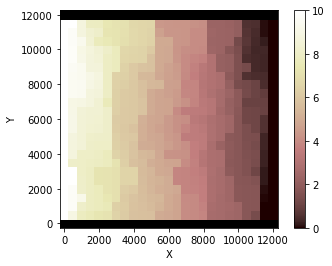

In [11]:
figure()
imshow_grid_at_node(mg, h)


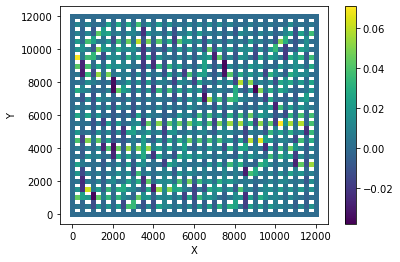

In [12]:
figure()
plot_links(mg, 'conduit__discharge', use_PIL=False)

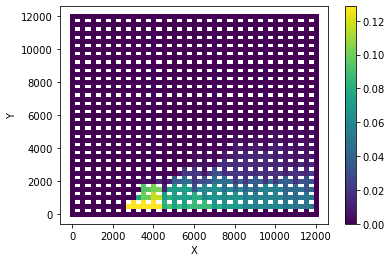

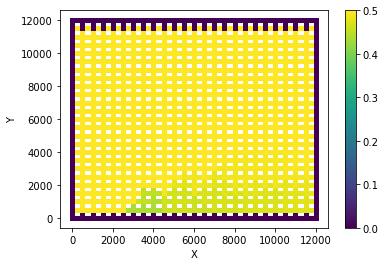

In [4]:
plot_links(mg, 'Ca__conc_in', use_PIL=False)
figure()
plot_links(mg, 'PCO2__conc_in', use_PIL=False)


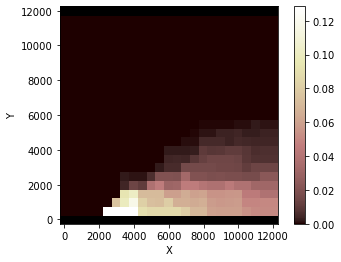

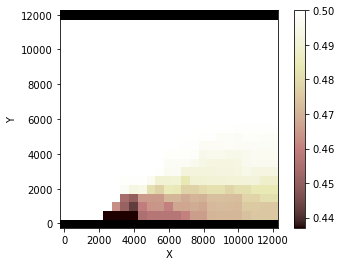

In [5]:
imshow_grid_at_node(mg, Ca)
figure()
imshow_grid_at_node(mg, PCO2)


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.25664353,  0.25671034,  0.25671034,  0.25671034,
        0.        ,  0.66957209,  0.26504717,  0.24119911,  0.24119911,
        0.        ,  0.0144084 ,  0.0144084 ,  0.0144084 ,  0.0144084 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

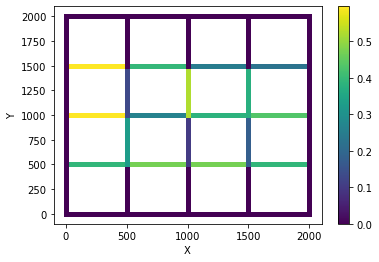

In [181]:
plot_links(mg, 'hydraulic__diameter', use_PIL=False)

In [7]:
this_node_links = mg.links_at_node[575]
this_node_dirs = mg.active_link_dirs_at_node[575]
print (this_node_dirs)
print(this_node_links)
node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
node_inflow_links = this_node_links[node_Qs>0]
node_outflow_links = this_node_links[node_Qs<0]
print(len(node_inflow_links))
print(node_outflow_links)

total_inflow = np.abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                            mg.at_node['input__discharge'][575]
print(total_inflow)


sum(np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['Ca__conc_out'][node_inflow_links])

[-1  0  0  0]
[1127 1151   -1 1102]
0
[1127]
0.0


0.0

In [13]:
np.argsort(-h)

array([575,  50, 500,  75, 475, 100, 450, 125, 425, 525, 150, 175, 375,
       200, 350, 225, 325, 250, 275, 400,  25, 300, 550, 326, 301, 226,
       276, 151, 351, 176, 426, 126, 101, 376, 401, 451, 251, 576, 201,
       501, 526, 476, 302, 551, 177, 477, 502, 202, 577, 527, 552, 152,
        76, 102,  77,  51,  26,  27,  52, 377, 127, 378, 578, 227, 402,
       403, 252, 277, 327, 352, 278, 253, 303, 228, 203, 353, 279, 304,
       328, 329, 229, 204, 254, 128, 354, 452, 427, 153, 355, 280, 255,
       230, 453, 428, 379, 231, 454, 429, 178, 179, 404, 479, 380, 180,
       478, 405, 103, 205, 430, 256,  78, 206, 181,  53,  28,  79,  54,
       104, 129, 154, 503, 528, 130, 553, 504, 529, 554, 579, 155, 455,
        29, 530, 480, 505, 580, 330,  30, 305, 555, 156, 356, 331, 381,
        55, 105, 106,  80,  81,  56,  31,  32, 131, 157,  57, 132, 182,
       556, 207,  82, 107, 158, 581, 506, 531, 481, 108, 133, 582, 456,
       557, 431, 532, 482, 507, 457, 406,  83, 257, 483, 508, 23

In [11]:
#Get index of nodes sorted by descending head
idx = np.argsort(-h)#Sort on negative to get descending order sort
#Loop through nodes from highest to lowest hydraulic head
for node_idx in idx:
    #Determine link indicies and directions for this node
    this_node_links = mg.links_at_node[node_idx]
    this_node_dirs = mg.active_link_dirs_at_node[node_idx]

    #Determine which links have inflow and outflow to/from node
    node_Qs = mg.at_link['conduit__discharge'][this_node_links]*this_node_dirs
    node_inflow_links = this_node_links[node_Qs>0]
    node_outflow_links = this_node_links[node_Qs<0]

    #Calculate node concentration from inflows (including boundary inflows)
    total_inflow = abs(mg.at_link['conduit__discharge'][node_inflow_links]).sum() + \
                    mg.at_node['input__discharge'][node_idx]

    #avoid cases with no inflow (e.g. closed boundaries)
    if total_inflow !=0:
        #Will need a loop here to loop through solutes
        conc_mult = np.abs(mg.at_link['conduit__discharge'][node_inflow_links])*mg.at_link['conduit__conc_out'][node_inflow_links]
        input_conc_mult = mg.at_node['input__discharge'][node_idx]*mg.at_node['input__concentration'][node_idx]
        conc_node = (conc_mult.sum() + input_conc_mult)/total_inflow
        C[node_idx] = conc_node
        
        #set outflow link concentrations
        mg.at_link['conduit__conc_in'][node_outflow_links] = conc_node
        
        #Calculate output link concentrations (for now conservative)
        mg.at_link['conduit__conc_out'][node_outflow_links] = mg.at_link['conduit__conc_in'][node_outflow_links]




FieldError: conduit__conc_out